In [1]:
import sys
sys.path.insert(0, '..')

In [42]:
import numpy as np
import pandas as pd
df = pd.read_parquet('data/eurovision-8columns-simple.parquet')
df[df['year'] == 2010].head()

,year,round,from_country_id,to_country_id,from_country,to_country,total_points,tele_points,jury_points,id,...,loudness.mean,loudness.std,pitchhist3.normentropy.minlog,mfcc.totvar.log,melody.mean,melody.std.log,roughness.mean.log,sharpness.mean,song.id,segment.id
24833,2010,final,al,de,Albania,Germany,10,NaN,NaN,649,...,-0.612784,-0.769922,-0.911731,0.704754,1.165758,1.266093,-0.755999,-0.43215,649,649
24834,2010,final,am,de,Armenia,Germany,0,NaN,NaN,649,...,-0.612784,-0.769922,-0.911731,0.704754,1.165758,1.266093,-0.755999,-0.43215,649,649
24835,2010,final,az,de,Azerbaijan,Germany,1,NaN,NaN,649,...,-0.612784,-0.769922,-0.911731,0.704754,1.165758,1.266093,-0.755999,-0.43215,649,649
24836,2010,final,by,de,Belarus,Germany,0,NaN,NaN,649,...,-0.612784,-0.769922,-0.911731,0.704754,1.165758,1.266093,-0.755999,-0.43215,649,649
24837,2010,final,be,de,Belgium,Germany,10,NaN,NaN,649,...,-0.612784,-0.769922,-0.911731,0.704754,1.165758,1.266093,-0.755999,-0.43215,649,649


In [175]:
from eurovision_dataset import EurovisionDataset

feature_columns = ['loudness.mean', 'loudness.std', 'pitchhist3.normentropy.minlog',
                   'mfcc.totvar.log', 'melody.mean', 'melody.std.log',
                   'roughness.mean.log', 'sharpness.mean']

dataset = EurovisionDataset(df, feature_columns)

In [4]:
from torch.utils.data import random_split

print("Dataset length: " + str(len(dataset)))
test_set_size = 250
train_set, test_set = random_split(dataset, [len(dataset) - test_set_size, test_set_size])

Dataset length: 1921


In [6]:
# Some random sample
sample_input, sample_order = train_set[0]
print(sample_input)
print(sample_order)

tensor([[-0.6179, -1.0279, -1.1532,  0.2669,  0.2224, -0.0807, -0.6801, -0.2901],
        [-0.9889,  0.0338,  1.1385,  1.7624, -0.8070, -0.8419, -1.0201, -0.9373],
        [-0.4826, -1.1322, -0.4885, -0.0409, -0.3581, -0.6332, -0.4387,  0.3076],
        [-0.9216, -0.7130, -0.9325,  1.6466, -0.2833,  0.5303, -0.7351,  1.2138],
        [-0.6728, -0.5827,  1.0841,  0.6039,  0.6026,  0.4622, -0.7760, -0.5907],
        [-0.8208, -1.0532, -0.5170,  1.0631,  0.5532,  0.2324, -0.6782,  0.4933],
        [-0.9185, -0.5668,  0.0586,  2.5919, -0.0090,  0.3667, -1.0338, -0.9432],
        [-1.3924, -0.7027, -1.2154,  1.3822, -0.8208, -0.4975, -1.5957, -1.2919],
        [-1.0835, -0.9170,  2.1372,  1.8418, -1.8370, -2.0897, -0.7588, -0.1994],
        [-0.9126, -0.9257,  0.8151, -0.0078, -0.5630, -0.6152, -0.4912,  0.3948],
        [-0.3312,  0.0317,  1.5214,  0.2965,  0.9568, -0.1275, -0.6098, -0.7820],
        [-0.7357, -0.6899, -0.2834, -0.0419, -0.2968,  0.4972, -0.5739,  1.6392],
        [-0.7600

In [22]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_set, shuffle=True)
test_loader = DataLoader(test_set)

In [29]:
import torch
from linear_model import LinearModel
from exploded_logit import ExplodedLogitLoss
from torch.utils.tensorboard import SummaryWriter

loss_type = 'nll'
regularization_lambda = 0.001

writer = SummaryWriter('runs/8columns/' + loss_type)

linear_model = LinearModel(8, 1)  # number of columns to score
optimizer = torch.optim.Adam(params=linear_model.parameters())
loss = ExplodedLogitLoss(loss_type=loss_type)

for epoch in range(100):
    for data, order in train_loader:
        optimizer.zero_grad()
        score = linear_model(data).squeeze(-1)
        
        loss_value = loss(score, order)
        
        l1_loss_value = 0
        for param in linear_model.parameters():
            l1_loss_value += torch.sum(torch.abs(param))
        loss_value += regularization_lambda * l1_loss_value
        
        loss_value.backward()
        optimizer.step()
        
        writer.add_scalar('training loss', loss_value.item())
    if epoch % 10 == 0:
        print("Loss value: {0}".format(loss_value.item()))


Loss value: 42.274756421342815
Loss value: 61.37977214160561
Loss value: 54.75536570149227
Loss value: 39.032554759099085
Loss value: 33.28244239466728
Loss value: 42.41839676634038
Loss value: 48.747199801890865
Loss value: 39.10811972232361
Loss value: 54.68073141554523
Loss value: 60.61213740101675


In [27]:
%load_ext tensorboard

In [30]:
%tensorboard --logdir="runs/8columns"

Reusing TensorBoard on port 6006 (pid 29992), started 0:05:05 ago. (Use '!kill 29992' to kill it.)

In [32]:
def get_sort_order(scores):
    s = torch.argsort(scores, descending=True)
    r = torch.zeros(scores.shape, dtype=torch.long)
    for i in range(scores.shape[-1]):
        r[0, s[0, i]] = i
    return r + 1

In [97]:
def precision_at_k(k, expected_order, actual_order):
    p = 0
    t = 0
    for i in range(1, k+1):
        idx = np.where(actual_order == i)
        if expected_order[idx] <= k:
            t += 1
            p += t/i
    return p/k
            
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 2, 3, 4, 5, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 4, 3, 2, 1])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 2, 4, 3, 5, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([1, 5, 4, 3, 2, 6])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 1, 3, 2, 4])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 2, 3, 4, 1])))
print(precision_at_k(3, np.asarray([1, 2, 3, 4, 5, 6]), np.asarray([6, 5, 3, 4, 2, 1])))

1.0
0.0
0.6666666666666666
0.3333333333333333
0.3333333333333333
0.16666666666666666
0.1111111111111111


In [171]:
test_size = len(test_loader)
at_k = 10
pk = np.zeros(at_k)  
lgths = []

num = 0
with torch.no_grad():
    for data, expected_order in test_loader:
        score = linear_model(data).squeeze(-1)
        
        actual_order = get_sort_order(score)
        
        if (len(expected_order.squeeze(0).numpy()) < 21):
            continue

        for k in range(1, at_k+1):
            p = precision_at_k(k, expected_order.squeeze(0).numpy(),
                               actual_order.squeeze(0).numpy())
#             print(p / test_size)
            pk[k-1] += p
        
        num += 1
        lgths.append(len(expected_order.squeeze(0).numpy()))
#         print("\n{0}\n{1}\n\n".format(actual_order, expected_order.view(1, -1)))
pk = pk / num

143


(array([12., 27., 13.,  0., 32., 35.,  0., 20.,  3.,  1.]),
 array([21. , 21.7, 22.4, 23.1, 23.8, 24.5, 25.2, 25.9, 26.6, 27.3, 28. ]),
 <BarContainer object of 10 artists>)

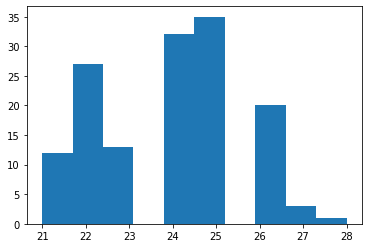

In [173]:
print(len(lgths))
plt.hist(lgths)

<BarContainer object of 10 artists>

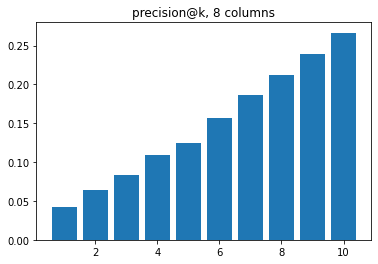

In [176]:
import matplotlib.pyplot as plt

plt.title('precision@k, 8 columns')
plt.bar(np.arange(1, at_k+1), pk)

In [121]:
hist_data = []

with torch.no_grad():
    t_equal = 0
    for _ in range(45):
        data, expected_order = next(test_iterator)

        score = linear_model(data).squeeze(-1)
        actual_order = get_sort_order(score)
        
        coeff = np.corrcoef(actual_order.view(-1), expected_order.view(-1))
        hist_data.append(coeff[0, 1])
#         plt.figure()
#         plt.scatter(actual_order, expected_order)
#         print("\n{0}\n{1}\n\n".format(actual_order, expected_order.view(1, -1)))

In [126]:
np.mean(np.asarray(hist_data))

0.112430289598594

In [102]:
import matplotlib.pyplot as plt

In [110]:
import numpy as np
np.corrcoef(actual_order.view(-1), expected_order.view(-1))

array([[ 1.        , -0.32982456],
       [-0.32982456,  1.        ]])